## EfficientNet-Based Concrete Crack Detection System - Part 2

This Jupyter notebook is the second part of the concrete crack detection system based on SDNET2018 dataset.
This part of the code concerns only model construction, training, evaluation, and prediction.
Please refer to the first part of the code, "Concrete Crack Detection SDNET2018 - Data.ipynb" for the data preparation portion of the code.

## Library Imports

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from itertools import product
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, recall_score, confusion_matrix
from matplotlib.ticker import FormatStrFormatter
from keras.preprocessing.image import load_img, img_to_array

np.random.seed(42)

## Hyperparameters

In [2]:
LEARNING_RATE = 1e-5 # lower initial learning rate due to use of transfer learning
TRAINING_EPOCHS = 30
BATCH_SIZE = 32

## Data Preparation

### 1) Reading data files from designated directory

In [3]:
dir_d_trn = os.getcwd() + "\\Data\\SDNET2018\\D\\train\\"
dir_d_tes = os.getcwd() + "\\Data\\SDNET2018\\D\\test\\"
dir_d_val = os.getcwd() + "\\Data\\SDNET2018\\D\\validation\\"

dir_p_trn = os.getcwd() + "\\Data\\SDNET2018\\P\\train\\"
dir_p_tes = os.getcwd() + "\\Data\\SDNET2018\\P\\test\\"
dir_p_val = os.getcwd() + "\\Data\\SDNET2018\\P\\validation\\"

dir_w_trn = os.getcwd() + "\\Data\\SDNET2018\\W\\train\\"
dir_w_tes = os.getcwd() + "\\Data\\SDNET2018\\W\\test\\"
dir_w_val = os.getcwd() + "\\Data\\SDNET2018\\W\\validation\\"

### 2) Processing data files into tf.dataset format

In [4]:
print("Processing Data - Deck")
tfd_d_trn = tf.keras.utils.image_dataset_from_directory(dir_d_trn)
tfd_d_tes = tf.keras.utils.image_dataset_from_directory(dir_d_tes)
tfd_d_val = tf.keras.utils.image_dataset_from_directory(dir_d_val)
print("")

print("Processing Data - Pavement")
tfd_p_trn = tf.keras.utils.image_dataset_from_directory(dir_p_trn)
tfd_p_tes = tf.keras.utils.image_dataset_from_directory(dir_p_tes)
tfd_p_val = tf.keras.utils.image_dataset_from_directory(dir_p_val)
print("")

print("Processing Data - Wall")
tfd_w_trn = tf.keras.utils.image_dataset_from_directory(dir_w_trn)
tfd_w_tes = tf.keras.utils.image_dataset_from_directory(dir_w_tes)
tfd_w_val = tf.keras.utils.image_dataset_from_directory(dir_w_val)
print("")

print("Processing Data - All") # Combined image dataset for Models 5 & 6
tfd_a_trn = tfd_d_trn.concatenate(tfd_p_trn).concatenate(tfd_w_trn)
tfd_a_tes = tfd_d_tes.concatenate(tfd_p_tes).concatenate(tfd_w_tes)
tfd_a_val = tfd_d_val.concatenate(tfd_p_val).concatenate(tfd_w_val)
print("Done!")

Processing Data - Deck
Found 9534 files belonging to 2 classes.
Found 2043 files belonging to 2 classes.
Found 2043 files belonging to 2 classes.

Processing Data - Pavement
Found 17034 files belonging to 2 classes.
Found 3650 files belonging to 2 classes.
Found 3650 files belonging to 2 classes.

Processing Data - Wall
Found 12698 files belonging to 2 classes.
Found 2720 files belonging to 2 classes.
Found 2720 files belonging to 2 classes.

Processing Data - All
Done!


## Model Preparation

### 1) Generalized function for model creation

In [5]:
def create_model(model_type="b0", augment=True):
    
    inputs = tf.keras.Input(shape=(256,256,3))
    
    data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"), # Random horizontal flipping of images
                                             tf.keras.layers.RandomFlip("vertical"), # Random vertical flipping of images
                                             tf.keras.layers.RandomRotation(0.2)]) # Random rotation of images
    
    if augment:
        x = data_augmentation(inputs)
    else:
        x = inputs
        
    if model_type == "b0":
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights="imagenet", input_shape=(256,256,3), include_top=False)
    elif model_type == "b2":
        base_model = tf.keras.applications.efficientnet.EfficientNetB2(weights="imagenet", input_shape=(256,256,3), include_top=False)
    else:
        print("Invalid model type. Please enter either 'b0' or 'b2' for model_type.")
        
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # Output was designated to be a sigmoid node as the desired format is binary

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

### 2) Defining callbacks

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=0, restore_best_weights=True)
learn_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=0, mode="auto", min_lr=1e-8)

## Model 1 - Separated Data, No Augmentation, Simple Model

### 1a) Initializing deck model

In [ ]:
model_1d = create_model(model_type="b0", augment=False)

### 1b) Training deck model

In [ ]:
model_1d_his = model_1d.fit(tfd_d_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_d_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_1d.save("efficientnetb0_d_nopreprocess.h5")
pd.DataFrame.from_dict(model_1d_his.history).to_csv("efficientnetb0_d_nopreprocess.csv")

### 1c) Plotting deck model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Bridge Deck Data")

ax[0].set_title("Losses")
ax[0].plot(model_1d_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_1d_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_1d_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_1d_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.02))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_1d_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 2a) Initializing pavement model

In [ ]:
model_1p = create_model(model_type="b0", augment=False)

### 2b) Training pavement model

In [ ]:
model_1p_his = model_p.fit(tfd_p_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_p_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_1p.save("efficientnetb0_p_nopreprocess.h5")
pd.DataFrame.from_dict(model_1p_his.history).to_csv("efficientnetb0_p_nopreprocess.csv")

### 2c) Plotting pavement model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Pavement Data")

ax[0].set_title("Losses")
ax[0].plot(model_1p_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_1p_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_1p_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_1p_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_1p_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 3a) Initializing wall model

In [ ]:
model_1w = create_model(model_type="b0", augment=False)

### 3b) Training wall model

In [ ]:
model_1w_his = model_w.fit(tfd_w_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_w_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_1w.save("efficientnetb0_w_nopreprocess.h5")
pd.DataFrame.from_dict(model_1w_his.history).to_csv("efficientnetb0_w_nopreprocess.csv")

### 3c) Plotting wall model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Wall Data")

ax[0].set_title("Losses")
ax[0].plot(model_1w_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_1w_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_1w_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_1w_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_1w_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Model 2 - Separated Data, Augmentation, Simple Model

### 1a) Initializing deck model

In [7]:
model_2d = create_model(model_type="b0", augment=True)

### 1b) Training deck model

In [8]:
model_2d_his = model_2d.fit(tfd_d_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_d_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_2d.save("efficientnetb0_d_preprocess.h5")
pd.DataFrame.from_dict(model_2d_his.history).to_csv("efficientnetb0_d_preprocess.csv")

Epoch 1/30
298/298 [==============================] - 129s 357ms/step - loss: 0.3256 - accuracy: 0.8832 - val_loss: 0.2516 - val_accuracy: 0.9148 - lr: 1.0000e-05
Epoch 2/30
298/298 [==============================] - 103s 347ms/step - loss: 0.2528 - accuracy: 0.9153 - val_loss: 0.2304 - val_accuracy: 0.9212 - lr: 1.0000e-05
Epoch 3/30
298/298 [==============================] - 104s 348ms/step - loss: 0.2405 - accuracy: 0.9180 - val_loss: 0.2208 - val_accuracy: 0.9261 - lr: 1.0000e-05
Epoch 4/30
298/298 [==============================] - 100s 336ms/step - loss: 0.2393 - accuracy: 0.9203 - val_loss: 0.2142 - val_accuracy: 0.9276 - lr: 1.0000e-05
Epoch 5/30
298/298 [==============================] - 104s 348ms/step - loss: 0.2311 - accuracy: 0.9224 - val_loss: 0.2170 - val_accuracy: 0.9305 - lr: 1.0000e-05
Epoch 6/30
298/298 [==============================] - 103s 346ms/step - loss: 0.2223 - accuracy: 0.9269 - val_loss: 0.2142 - val_accuracy: 0.9261 - lr: 1.0000e-05
Epoch 7/30
298/298 [==

### 1c) Plotting deck model training curves

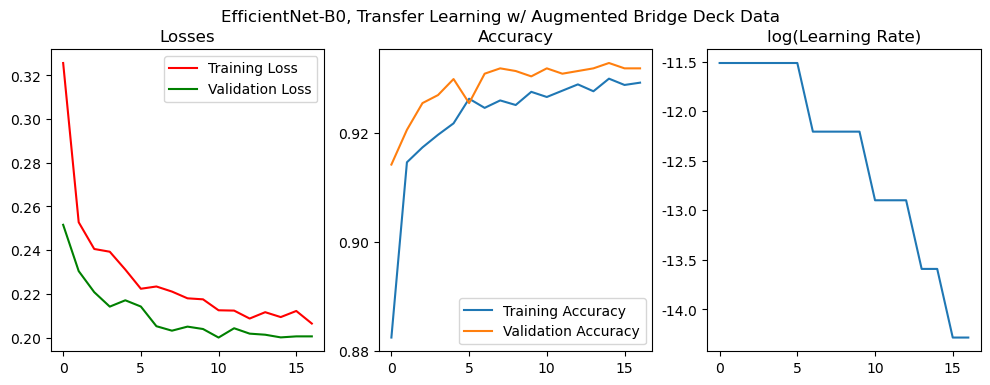

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Augmented Bridge Deck Data")

ax[0].set_title("Losses")
ax[0].plot(model_2d_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_2d_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_2d_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_2d_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.02))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_2d_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 2a) Initializing pavement model

In [10]:
model_2p = create_model(model_type="b0", augment=True)

### 2b) Training pavement model

In [11]:
model_2p_his = model_2p.fit(tfd_p_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_p_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_2p.save("efficientnetb0_p_preprocess.h5")
pd.DataFrame.from_dict(model_2p_his.history).to_csv("efficientnetb0_p_preprocess.csv")

Epoch 1/30
533/533 [==============================] - 192s 336ms/step - loss: 0.2264 - accuracy: 0.9243 - val_loss: 0.1494 - val_accuracy: 0.9518 - lr: 1.0000e-05
Epoch 2/30
533/533 [==============================] - 175s 327ms/step - loss: 0.1627 - accuracy: 0.9471 - val_loss: 0.1233 - val_accuracy: 0.9573 - lr: 1.0000e-05
Epoch 3/30
533/533 [==============================] - 185s 347ms/step - loss: 0.1518 - accuracy: 0.9505 - val_loss: 0.1248 - val_accuracy: 0.9581 - lr: 1.0000e-05
Epoch 4/30
533/533 [==============================] - 197s 370ms/step - loss: 0.1468 - accuracy: 0.9520 - val_loss: 0.1097 - val_accuracy: 0.9616 - lr: 1.0000e-05
Epoch 5/30
533/533 [==============================] - 165s 309ms/step - loss: 0.1384 - accuracy: 0.9549 - val_loss: 0.1091 - val_accuracy: 0.9622 - lr: 1.0000e-05
Epoch 6/30
533/533 [==============================] - 164s 307ms/step - loss: 0.1354 - accuracy: 0.9563 - val_loss: 0.1025 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 7/30
533/533 [==

### 2c) Plotting pavement model training curves

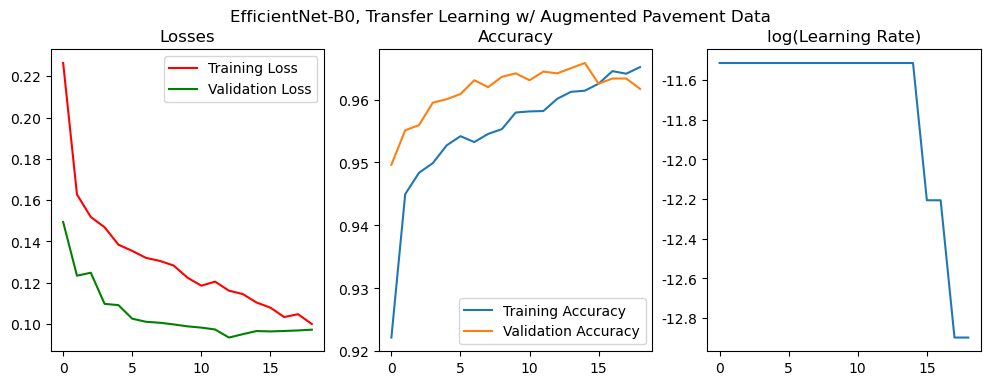

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Augmented Pavement Data")

ax[0].set_title("Losses")
ax[0].plot(model_2p_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_2p_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_2p_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_2p_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_2p_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 3a) Initializing wall model

In [13]:
model_2w = create_model(model_type="b0", augment=True)

### 3b) Training wall model

In [14]:
model_2w_his = model_2w.fit(tfd_w_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_w_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_2w.save("efficientnetb0_w_preprocess.h5")
pd.DataFrame.from_dict(model_2w_his.history).to_csv("efficientnetb0_w_preprocess.csv")

Epoch 1/30
397/397 [==============================] - 141s 325ms/step - loss: 0.3263 - accuracy: 0.8742 - val_loss: 0.2330 - val_accuracy: 0.9147 - lr: 1.0000e-05
Epoch 2/30
397/397 [==============================] - 123s 311ms/step - loss: 0.2398 - accuracy: 0.9134 - val_loss: 0.2159 - val_accuracy: 0.9191 - lr: 1.0000e-05
Epoch 3/30
397/397 [==============================] - 125s 315ms/step - loss: 0.2282 - accuracy: 0.9179 - val_loss: 0.2049 - val_accuracy: 0.9243 - lr: 1.0000e-05
Epoch 4/30
397/397 [==============================] - 128s 323ms/step - loss: 0.2234 - accuracy: 0.9196 - val_loss: 0.2038 - val_accuracy: 0.9228 - lr: 1.0000e-05
Epoch 5/30
397/397 [==============================] - 132s 332ms/step - loss: 0.2255 - accuracy: 0.9199 - val_loss: 0.2027 - val_accuracy: 0.9246 - lr: 1.0000e-05
Epoch 6/30
397/397 [==============================] - 134s 336ms/step - loss: 0.2179 - accuracy: 0.9224 - val_loss: 0.1987 - val_accuracy: 0.9265 - lr: 1.0000e-05
Epoch 7/30
397/397 [==

### 3c) Plotting wall model training curves

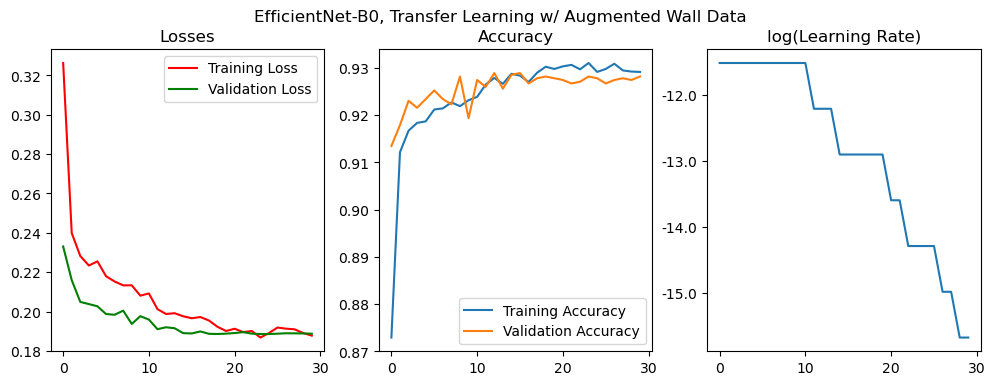

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Augmented Wall Data")

ax[0].set_title("Losses")
ax[0].plot(model_2w_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_2w_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_2w_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_2w_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_2w_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Model 3 - Separated Data, No Augmentation, Complex Model

### 1a) Initializing deck model

In [ ]:
model_3d = create_model(model_type="b2", augment=False)

### 1b) Training deck model

In [ ]:
model_3d_his = model_3d.fit(tfd_d_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_d_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_3d.save("efficientnetb2_d_nopreprocess.h5")
pd.DataFrame.from_dict(model_3d_his.history).to_csv("efficientnetb2_d_nopreprocess.csv")

### 1c) Plotting deck model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Bridge Deck Data")

ax[0].set_title("Losses")
ax[0].plot(model_3d_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_3d_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_3d_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_3d_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.02))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_3d_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 2a) Initializing pavement model

In [ ]:
model_3p = create_model(model_type="b2", augment=False)

### 2b) Training pavement model

In [ ]:
model_3p_his = model_3p.fit(tfd_p_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_p_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_3p.save("efficientnetb2_p_nopreprocess.h5")
pd.DataFrame.from_dict(model_3p_his.history).to_csv("efficientnetb2_p_nopreprocess.csv")

### 2c) Plotting pavement model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Pavement Data")

ax[0].set_title("Losses")
ax[0].plot(model_3p_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_3p_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_3p_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_3p_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_3p_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 3a) Initializing wall model

In [ ]:
model_3w = create_model(model_type="b2", augment=False)

### 3b) Training wall model

In [ ]:
model_3w_his = model_3w.fit(tfd_w_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_w_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_3w.save("efficientnetb2_w_nopreprocess.h5")
pd.DataFrame.from_dict(model_3w_his.history).to_csv("efficientnetb2_w_nopreprocess.csv")

### 3c) Plotting wall model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Wall Data")

ax[0].set_title("Losses")
ax[0].plot(model_3w_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_3w_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_3w_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_3w_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_3w_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Model 4 - Separated Data, Augmentation, Complex Model

### 1a) Initializing deck model

In [ ]:
model_4d = create_model(model_type="b2", augment=True)

### 1b) Training deck model

In [ ]:
model_4d_his = model_4d.fit(tfd_d_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_d_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_4d.save("efficientnetb2_d_preprocess.h5")
pd.DataFrame.from_dict(model_4d_his.history).to_csv("efficientnetb2_d_preprocess.csv")

### 1c) Plotting deck model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Augmented Bridge Deck Data")

ax[0].set_title("Losses")
ax[0].plot(model_4d_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_4d_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_4d_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_4d_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.02))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_4d_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 2a) Initializing pavement model

In [ ]:
model_4p = create_model(model_type="b2", augment=True)

### 2b) Training pavement model

In [ ]:
model_4p_his = model_4p.fit(tfd_p_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_p_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_4p.save("efficientnetb2_p_preprocess.h5")
pd.DataFrame.from_dict(model_4p_his.history).to_csv("efficientnetb2_p_preprocess.csv")

### 2c) Plotting pavement model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Augmented Pavement Data")

ax[0].set_title("Losses")
ax[0].plot(model_4p_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_4p_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_4p_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_4p_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_4p_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

### 3a) Initializing wall model

In [ ]:
model_4w = create_model(model_type="b2", augment=True)

### 3b) Training wall model

In [ ]:
model_4w_his = model_4w.fit(tfd_w_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_w_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_4w.save("efficientnetb2_w_preprocess.h5")
pd.DataFrame.from_dict(model_4w_his.history).to_csv("efficientnetb2_w_preprocess.csv")

### 3c) Plotting wall model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B2, Transfer Learning w/ Augmented Wall Data")

ax[0].set_title("Losses")
ax[0].plot(model_4w_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_4w_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_4w_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_4w_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_4w_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Model 5 - Combined Data, No Augmentation, Simple Model

### 1a) Initializing combined model

In [ ]:
model_5 = create_model(model_type='b0', augment=False)

### 1b) Training combined model

In [ ]:
model_5_his = model_5.fit(tfd_a_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_a_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_5.save("efficientnetb0_a_nopreprocess.h5")
pd.DataFrame.from_dict(model_5_his.history).to_csv("efficientnetb0_a_nopreprocess.csv")

### 1c) Plotting combined model training curves

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Combined Data")

ax[0].set_title("Losses")
ax[0].plot(model_5_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_5_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_5_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_5_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_5_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Model 6 - Combined Data, Augmentation, Simple Model

### 1a) Initializing combined model

In [16]:
model_6 = create_model(model_type='b0', augment=True)

### 1b) Training combined model

In [17]:
model_6_his = model_6.fit(tfd_a_trn, epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_data=tfd_a_val, callbacks=[early_stopping, learn_schedule], verbose=1)

model_6.save("efficientnetb0_a_preprocess.h5")
pd.DataFrame.from_dict(model_6_his.history).to_csv("efficientnetb0_a_preprocess.csv")

Epoch 1/30
1228/1228 [==============================] - 387s 307ms/step - loss: 0.2450 - accuracy: 0.9142 - val_loss: 0.2059 - val_accuracy: 0.9273 - lr: 1.0000e-05
Epoch 2/30
1228/1228 [==============================] - 375s 305ms/step - loss: 0.2069 - accuracy: 0.9303 - val_loss: 0.1822 - val_accuracy: 0.9356 - lr: 1.0000e-05
Epoch 3/30
1228/1228 [==============================] - 376s 306ms/step - loss: 0.1969 - accuracy: 0.9323 - val_loss: 0.1861 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 4/30
1228/1228 [==============================] - 376s 306ms/step - loss: 0.1918 - accuracy: 0.9348 - val_loss: 0.1729 - val_accuracy: 0.9419 - lr: 1.0000e-05
Epoch 5/30
1228/1228 [==============================] - 375s 305ms/step - loss: 0.1884 - accuracy: 0.9359 - val_loss: 0.1695 - val_accuracy: 0.9426 - lr: 1.0000e-05
Epoch 6/30
1228/1228 [==============================] - 376s 306ms/step - loss: 0.1835 - accuracy: 0.9375 - val_loss: 0.1629 - val_accuracy: 0.9431 - lr: 1.0000e-05
Epoch 7/30

### 1c) Plotting combined model training curves

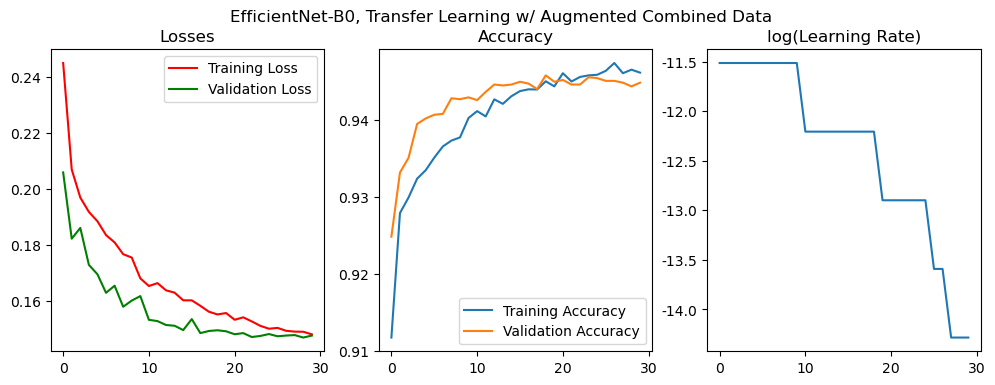

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

fig.suptitle("EfficientNet-B0, Transfer Learning w/ Augmented Combined Data")

ax[0].set_title("Losses")
ax[0].plot(model_6_his.history["loss"], color="red", label="Training Loss")
ax[0].plot(model_6_his.history["val_loss"], color="green", label="Validation Loss")
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(model_6_his.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_6_his.history["val_accuracy"], label="Validation Accuracy")
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
start, end = ax[1].get_ylim()
ax[1].yaxis.set_ticks(np.arange(start, end, 0.01))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax[1].legend()

ax[2].set_title("log(Learning Rate)")
ax[2].plot(np.log(model_6_his.history["lr"]))
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"));

## Trained Model Loading (use if previous training steps were skipped)

In [19]:
model_1d = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_d_nopreprocess.h5")
model_1p = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_p_nopreprocess.h5")
model_1w = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_w_nopreprocess.h5")

model_2d = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_d_preprocess.h5")
model_2p = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_p_preprocess.h5")
model_2w = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_w_preprocess.h5")

model_3d = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_d_nopreprocess.h5")
model_3p = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_p_nopreprocess.h5")
model_3w = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_w_nopreprocess.h5")

model_4d = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_d_preprocess.h5")
model_4p = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_p_preprocess.h5")
model_4w = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb2_w_preprocess.h5")

model_5 = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_a_nopreprocess.h5")

model_6 = tf.keras.models.load_model(os.getcwd() + "\\Trained Models\\efficientnetb0_a_preprocess.h5")

## Model Evaluation

### 1) Generation of prediction

In [21]:
pred_1d = np.array([])
pred_2d = np.array([])
pred_3d = np.array([])
pred_4d = np.array([])
pred_5d = np.array([])
pred_6d = np.array([])

pred_1p = np.array([])
pred_2p = np.array([])
pred_3p = np.array([])
pred_4p = np.array([])
pred_5p = np.array([])
pred_6p = np.array([])

pred_1w = np.array([])
pred_2w = np.array([])
pred_3w = np.array([])
pred_4w = np.array([])
pred_5w = np.array([])
pred_6w = np.array([])

pred_5a = np.array([])
pred_6a = np.array([])

label_d = np.array([])
label_p = np.array([])
label_w = np.array([])
label_a = np.array([])

for x, y in tqdm(tfd_d_tes):
    pred_1d = np.concatenate((pred_1d, model_1d.predict(x).flatten()))
    pred_2d = np.concatenate((pred_2d, model_2d.predict(x).flatten()))
    pred_3d = np.concatenate((pred_3d, model_3d.predict(x).flatten()))
    pred_4d = np.concatenate((pred_4d, model_4d.predict(x).flatten()))
    pred_5d = np.concatenate((pred_5d, model_5.predict(x).flatten()))
    pred_6d = np.concatenate((pred_6d, model_6.predict(x).flatten()))
    label_d = np.concatenate((label_d, y.numpy().flatten()))    
    
for x, y in tqdm(tfd_p_tes):
    pred_1p = np.concatenate((pred_1p, model_1p.predict(x).flatten()))
    pred_2p = np.concatenate((pred_2p, model_2p.predict(x).flatten()))
    pred_3p = np.concatenate((pred_3p, model_3p.predict(x).flatten()))
    pred_4p = np.concatenate((pred_4p, model_4p.predict(x).flatten()))
    pred_5p = np.concatenate((pred_5p, model_5.predict(x).flatten()))
    pred_6p = np.concatenate((pred_6p, model_6.predict(x).flatten()))
    label_p = np.concatenate((label_p, y.numpy().flatten()))    
    
for x, y in tqdm(tfd_w_tes):
    pred_1w = np.concatenate((pred_1w, model_1w.predict(x).flatten()))
    pred_2w = np.concatenate((pred_2w, model_2w.predict(x).flatten()))
    pred_3w = np.concatenate((pred_3w, model_3w.predict(x).flatten()))
    pred_4w = np.concatenate((pred_4w, model_4w.predict(x).flatten()))
    pred_5w = np.concatenate((pred_5w, model_5.predict(x).flatten()))
    pred_6w = np.concatenate((pred_6w, model_6.predict(x).flatten()))
    label_w = np.concatenate((label_w, y.numpy().flatten()))
    
for x, y in tqdm(tfd_a_tes):
    pred_5a = np.concatenate((pred_5a, model_5.predict(x).flatten()))
    pred_6a = np.concatenate((pred_6a, model_6.predict(x).flatten()))
    label_a = np.concatenate((label_a, y.numpy().flatten()))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [01:13<00:00,  3.59it/s]


### 1b) Populating the predictions into a pandas dataframe

In [22]:
deck = pd.DataFrame({"true_label": label_d, "model_1": pred_1d, "model_2": pred_2d, "model_3": pred_3d, "model_4": pred_4d, "model_5": pred_5d, "model_6": pred_6d})
pave = pd.DataFrame({"true_label": label_p, "model_1": pred_1p, "model_2": pred_2p, "model_3": pred_3p, "model_4": pred_4p, "model_5": pred_5p, "model_6": pred_6p})
wall = pd.DataFrame({"true_label": label_w, "model_1": pred_1w, "model_2": pred_2w, "model_3": pred_3w, "model_4": pred_4w, "model_5": pred_5w, "model_6": pred_6w})

cons = pd.DataFrame({"true_label": label_a, "model_5": pred_5a, "model_6": pred_6a})

### 1c) Plotting Receiver Operating Characteristic (ROC) Curve, and calculating the Area-Under-the-Curve (AUC)

In [23]:
model_1d_roc = roc_curve(deck["true_label"], deck["model_1"])
model_1p_roc = roc_curve(pave["true_label"], pave["model_1"])
model_1w_roc = roc_curve(wall["true_label"], wall["model_1"])

model_2d_roc = roc_curve(deck["true_label"], deck["model_2"])
model_2p_roc = roc_curve(pave["true_label"], pave["model_2"])
model_2w_roc = roc_curve(wall["true_label"], wall["model_2"])

model_3d_roc = roc_curve(deck["true_label"], deck["model_3"])
model_3p_roc = roc_curve(pave["true_label"], pave["model_3"])
model_3w_roc = roc_curve(wall["true_label"], wall["model_3"])

model_4d_roc = roc_curve(deck["true_label"], deck["model_4"])
model_4p_roc = roc_curve(pave["true_label"], pave["model_4"])
model_4w_roc = roc_curve(wall["true_label"], wall["model_4"])

model_5_roc = roc_curve(cons["true_label"], cons["model_5"])
model_5d_roc = roc_curve(deck["true_label"], deck["model_5"])
model_5p_roc = roc_curve(pave["true_label"], pave["model_5"])
model_5w_roc = roc_curve(wall["true_label"], wall["model_5"])

model_6_roc = roc_curve(cons["true_label"], cons["model_6"])
model_6d_roc = roc_curve(deck["true_label"], deck["model_6"])
model_6p_roc = roc_curve(pave["true_label"], pave["model_6"])
model_6w_roc = roc_curve(wall["true_label"], wall["model_6"])

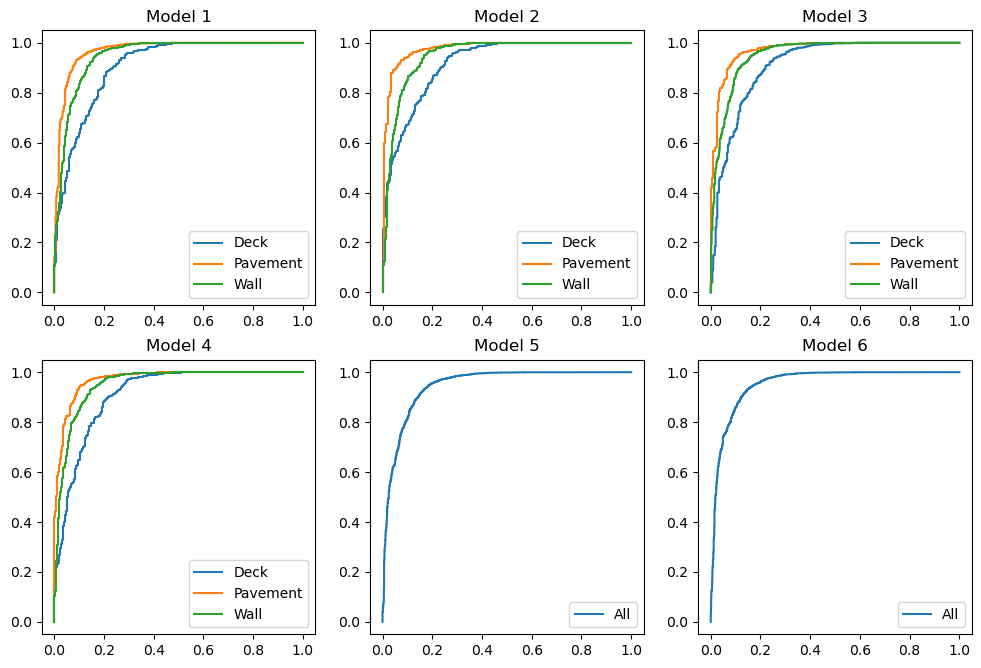

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=100)

ax[0, 0].set_title("Model 1")
ax[0, 0].plot(model_1d_roc[0], model_1d_roc[1], label="Deck")
ax[0, 0].plot(model_1p_roc[0], model_1p_roc[1], label="Pavement")
ax[0, 0].plot(model_1w_roc[0], model_1w_roc[1], label="Wall")
ax[0, 0].legend();

ax[0, 1].set_title("Model 2")
ax[0, 1].plot(model_2d_roc[0], model_2d_roc[1], label="Deck")
ax[0, 1].plot(model_2p_roc[0], model_2p_roc[1], label="Pavement")
ax[0, 1].plot(model_2w_roc[0], model_2w_roc[1], label="Wall")
ax[0, 1].legend();

ax[0, 2].set_title("Model 3")
ax[0, 2].plot(model_3d_roc[0], model_3d_roc[1], label="Deck")
ax[0, 2].plot(model_3p_roc[0], model_3p_roc[1], label="Pavement")
ax[0, 2].plot(model_3w_roc[0], model_3w_roc[1], label="Wall")
ax[0, 2].legend();

ax[1, 0].set_title("Model 4")
ax[1, 0].plot(model_4d_roc[0], model_4d_roc[1], label="Deck")
ax[1, 0].plot(model_4p_roc[0], model_4p_roc[1], label="Pavement")
ax[1, 0].plot(model_4w_roc[0], model_4w_roc[1], label="Wall")
ax[1, 0].legend();

ax[1, 1].set_title("Model 5")
ax[1, 1].plot(model_5_roc[0], model_5_roc[1], label="All")
ax[1, 1].legend();

ax[1, 2].set_title("Model 6")
ax[1, 2].plot(model_6_roc[0], model_6_roc[1], label="All")
ax[1, 2].legend();

In [25]:
model_1d_auc = roc_auc_score(deck["true_label"], deck["model_1"])
model_1p_auc = roc_auc_score(pave["true_label"], pave["model_1"])
model_1w_auc = roc_auc_score(wall["true_label"], wall["model_1"])

model_2d_auc = roc_auc_score(deck["true_label"], deck["model_2"])
model_2p_auc = roc_auc_score(pave["true_label"], pave["model_2"])
model_2w_auc = roc_auc_score(wall["true_label"], wall["model_2"])

model_3d_auc = roc_auc_score(deck["true_label"], deck["model_3"])
model_3p_auc = roc_auc_score(pave["true_label"], pave["model_3"])
model_3w_auc = roc_auc_score(wall["true_label"], wall["model_3"])

model_4d_auc = roc_auc_score(deck["true_label"], deck["model_4"])
model_4p_auc = roc_auc_score(pave["true_label"], pave["model_4"])
model_4w_auc = roc_auc_score(wall["true_label"], wall["model_4"])

model_5_auc = roc_auc_score(cons["true_label"], cons["model_5"])
model_5d_auc = roc_auc_score(deck["true_label"], deck["model_5"])
model_5p_auc = roc_auc_score(pave["true_label"], pave["model_5"])
model_5w_auc = roc_auc_score(wall["true_label"], wall["model_5"])

model_6_auc = roc_auc_score(cons["true_label"], cons["model_6"])
model_6d_auc = roc_auc_score(deck["true_label"], deck["model_6"])
model_6p_auc = roc_auc_score(pave["true_label"], pave["model_6"])
model_6w_auc = roc_auc_score(wall["true_label"], wall["model_6"])

In [31]:
print("Model 1 (Deck) ROC-AUC: {:.4f}\t".format(model_1d_auc), "Model 1 (Pavement) ROC-AUC: {:.4f}\t".format(model_1p_auc), "Model 1 (Wall) ROC-AUC: {:.4f}\t".format(model_1w_auc))
print("Model 2 (Deck) ROC-AUC: {:.4f}\t".format(model_2d_auc), "Model 2 (Pavement) ROC-AUC: {:.4f}\t".format(model_2p_auc), "Model 2 (Wall) ROC-AUC: {:.4f}\t".format(model_2w_auc))
print("Model 3 (Deck) ROC-AUC: {:.4f}\t".format(model_3d_auc), "Model 3 (Pavement) ROC-AUC: {:.4f}\t".format(model_3p_auc), "Model 3 (Wall) ROC-AUC: {:.4f}\t".format(model_3w_auc))
print("Model 4 (Deck) ROC-AUC: {:.4f}\t".format(model_4d_auc), "Model 4 (Pavement) ROC-AUC: {:.4f}\t".format(model_4p_auc), "Model 4 (Wall) ROC-AUC: {:.4f}\t".format(model_4w_auc))
print("Model 5 (Deck) ROC-AUC: {:.4f}\t".format(model_5d_auc), "Model 5 (Pavement) ROC-AUC: {:.4f}\t".format(model_5p_auc), "Model 5 (Wall) ROC-AUC: {:.4f}\t".format(model_5w_auc), "Model 5 (All) ROC-AUC: {:.4f}\t".format(model_5_auc))
print("Model 6 (Deck) ROC-AUC: {:.4f}\t".format(model_6d_auc), "Model 6 (Pavement) ROC-AUC: {:.4f}\t".format(model_6p_auc), "Model 6 (Wall) ROC-AUC: {:.4f}\t".format(model_6w_auc), "Model 6 (All) ROC-AUC: {:.4f}\t".format(model_6_auc))

Model 1 (Deck) ROC-AUC: 0.9064	 Model 1 (Pavement) ROC-AUC: 0.9686	 Model 1 (Wall) ROC-AUC: 0.9479	
Model 2 (Deck) ROC-AUC: 0.9173	 Model 2 (Pavement) ROC-AUC: 0.9754	 Model 2 (Wall) ROC-AUC: 0.9483	
Model 3 (Deck) ROC-AUC: 0.9120	 Model 3 (Pavement) ROC-AUC: 0.9720	 Model 3 (Wall) ROC-AUC: 0.9526	
Model 4 (Deck) ROC-AUC: 0.9111	 Model 4 (Pavement) ROC-AUC: 0.9716	 Model 4 (Wall) ROC-AUC: 0.9516	
Model 5 (Deck) ROC-AUC: 0.8963	 Model 5 (Pavement) ROC-AUC: 0.9616	 Model 5 (Wall) ROC-AUC: 0.9468	 Model 5 (All) ROC-AUC: 0.9459	
Model 6 (Deck) ROC-AUC: 0.9164	 Model 6 (Pavement) ROC-AUC: 0.9722	 Model 6 (Wall) ROC-AUC: 0.9500	 Model 6 (All) ROC-AUC: 0.9541	


### 1d) Binarize the prediction values using threshold of P>0.5

In [32]:
def binarize(x):
    if x > 0.5:
        return 1
    else:
        return 0

deck["model_2_bin"] = deck["model_2"].apply(binarize)
pave["model_2_bin"] = pave["model_2"].apply(binarize)
wall["model_2_bin"] = wall["model_2"].apply(binarize)

cons["model_6_bin"] = cons["model_6"].apply(binarize)

### 1e) Calculate precision, recall, and F1-score.

In [34]:
print("Model 2 (Deck) Sensitivity:", recall_score(deck["true_label"], deck["model_2_bin"], pos_label=0))
print("Model 2 (Pavement) Sensitivity:", recall_score(pave["true_label"], pave["model_2_bin"], pos_label=0))
print("Model 2 (Wall) Sensitivity:", recall_score(wall["true_label"], wall["model_2_bin"], pos_label=0))

print("Model 6 Sensitivity:", recall_score(cons["true_label"], cons["model_6_bin"], pos_label=0))

Model 2 (Deck) Sensitivity: 0.5986842105263158
Model 2 (Pavement) Sensitivity: 0.7621483375959079
Model 2 (Wall) Sensitivity: 0.7629757785467128
Model 6 Sensitivity: 0.7282010997643362


In [36]:
print("Model 2 (Deck) Precision, Recall, F1-Score:", precision_recall_fscore_support(deck["true_label"], deck["model_2_bin"], average="binary"))
print("Model 2 (Pavement) Precision, Recall, F1-Score:", precision_recall_fscore_support(pave["true_label"], pave["model_2_bin"], average="binary"))
print("Model 2 (Wall) Precision, Recall, F1-Score:", precision_recall_fscore_support(wall["true_label"], wall["model_2_bin"], average="binary"))

print("Model 6 Precision, Recall, F1-Score:", precision_recall_fscore_support(cons["true_label"], cons["model_6_bin"], average="binary"))

Model 2 (Deck) Precision, Recall, F1-Score: (0.9336235038084875, 0.9867740080506038, 0.9594632373497344, None)
Model 2 (Pavement) Precision, Recall, F1-Score: (0.971894832275612, 0.9868057686406874, 0.9792935444579782, None)
Model 2 (Wall) Precision, Recall, F1-Score: (0.9388938447814451, 0.9827264239028944, 0.9603102189781022, None)
Model 6 Precision, Recall, F1-Score: (0.9531292332701164, 0.9854341736694678, 0.9690125327089932, None)


## Visualize CNN Feature Map

In [37]:
def visualize_feature_map(model, image_dir):
    
    ixs = []
    layers = ["block1a_project_bn", "block2a_project_bn", "block3a_project_bn", "block4a_project_bn", "block5a_project_bn", "block6a_project_bn", "block7a_project_bn"]

    for idx, layer in enumerate(model_1d.layers[1].layers):
        if layer.name in layers:
            ixs.append(idx)

    outputs = [model.layers[2].layers[i].output for i in ixs]
    model = tf.keras.Model(inputs=model.layers[2].inputs, outputs=outputs)

    img = load_img(image_dir, target_size=(256, 256))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    feature_maps = model.predict(img)
    
    square = 4
    for fmap in feature_maps:
        ix = 1
        for _ in range(square):
            for _ in range(square):
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                
                plt.imshow(fmap[0, :, :, ix-1], cmap="viridis")
                
                ix += 1
        plt.show()

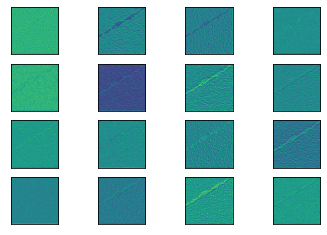

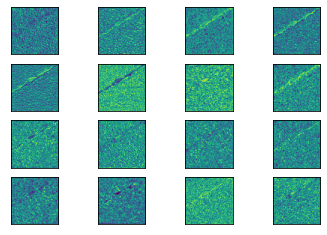

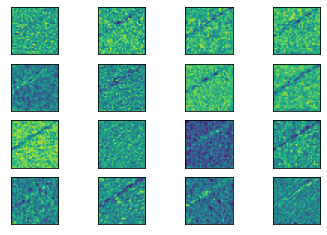

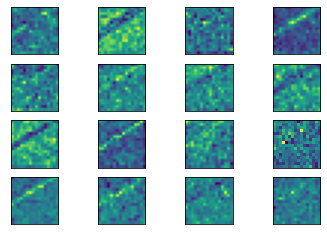

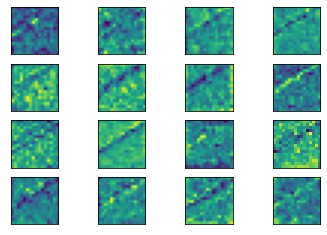

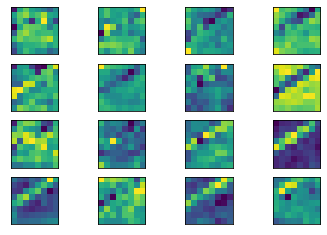

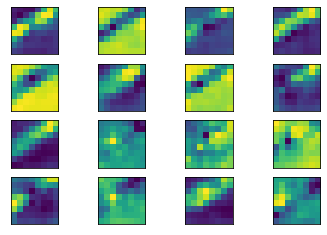

In [38]:
visualize_feature_map(model_6, "C:/Users/KC/Documents/Uni/SEM 4/Deep Learning/Assignment/Code/Data/SDNET2018/P/test/Cracked/006-153.jpg")

## Isolating Misclassfied Image Samples

In [39]:
mismatch = list()

for x, y in tqdm(tfd_a_tes.unbatch()):
    pred = model_6.predict(np.expand_dims(x, axis=0))[0][0]
    true = y.numpy()
    
    if (true==0) & (binarize(pred)==1):
        mismatch.append(x)
        
mismatch = np.array(mismatch)

8413it [11:49, 11.85it/s]


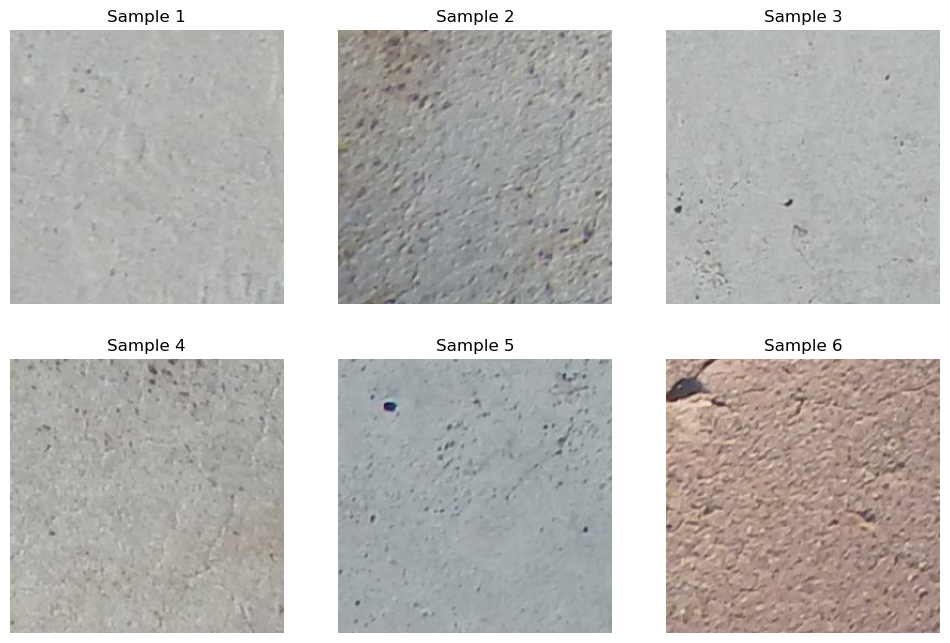

In [41]:
np.random.seed(42)
sam = np.random.choice(len(mismatch), 6, replace=False)

fig, ax = plt.subplots(2, 3, figsize=(12,8), dpi=100)

for i, (row, col) in enumerate(product([0, 1], [0, 1, 2])):
    ax[row, col].imshow(mismatch[sam[i]]/255)
    ax[row, col].set_title("Sample "+str(i+1))
    ax[row, col].axis("off")